In [1]:
%cd ../

/Users/kevinhe/Documents/UHN/Projects/model-deployer


In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 500)

# Load Data

In [3]:
data_dir = "./Data/silent_deployment"

In [4]:
visits = pd.read_csv(f"{data_dir}/AIM2REDUCE_visits_20251020.csv", parse_dates=["APPT_DATE_TIME"])
visits["CONTACT_DATE"] = pd.to_datetime(visits["CONTACT_DATE"])
visits = visits[visits["DEPARTMENT_SPECIALTY"] == "Oncology OP"]
visits = visits[visits["ENCOUNTER_STATUS"] == "Completed"]
visits = visits[visits["ENCOUNTER_TYPE"].isin(["Consult", "Office Visit", "Follow-Up"])]
visits = visits.rename(
    columns={"PATIENT_ID": "mrn", "CONTACT_DATE": "visit_date", "VISIT_PROVIDER_NAME": "visit_provider"}
)
visits = visits[["mrn", "visit_date", "visit_provider"]].drop_duplicates()

In [5]:
chemo = pd.read_csv(f"{data_dir}/AIM2REDUCE_chemo_20251017.csv", dtype={"CANCEL_DAY_REASON": str})
chemo["TRT_DATE_UTC"] = pd.to_datetime(chemo["TRT_DATE_UTC"], format="%b %d %Y %I:%M%p")
chemo["FIRST_TRT_DATE_UTC"] = pd.to_datetime(chemo["FIRST_TRT_DATE_UTC"])
chemo["department"] = chemo["REGIMEN"].str.split(" ").str[0]
chemo = chemo.rename(columns={"RESEARCH_ID": "mrn", "TRT_DATE_UTC": "trt_date", "FIRST_TRT_DATE_UTC": "first_trt_date"})
chemo = chemo.sort_values(by=["mrn", "trt_date"])
chemo = chemo[["mrn", "trt_date", "first_trt_date", "department"]].drop_duplicates()
chemo = chemo[
    chemo["trt_date"].dt.date == chemo["first_trt_date"].dt.date
]  # only take the first treatment date per patient

In [6]:
ED_visits = pd.read_csv(f"{data_dir}/AIM2REDUCE_ED_visits_20251017.csv", parse_dates=["EMERGENCY_ADMISSION_DATE"])
ED_visits = ED_visits.rename(columns={"PATIENT_ID": "mrn", "EMERGENCY_ADMISSION_DATE": "ed_admission_date"})
ED_visits = ED_visits[["mrn", "ed_admission_date"]].drop_duplicates()

In [7]:
min_date = "2024-03-01"
max_date = "2025-03-20"
# only include patients who had their first trt date during silent deployment
assert chemo["first_trt_date"].between(min_date, max_date).all()

df = pd.merge(chemo, visits, on="mrn", how="left")

print(f"Before: {df['mrn'].nunique()} patients")

# only take patients who had a clinic visit 30 days prior to first treatment day
low, high = df["trt_date"] - pd.Timedelta(days=30), df["trt_date"]
df = df[df["visit_date"].between(low, high)].drop_duplicates(subset="mrn")

print(f"After: {df['mrn'].nunique()} patients")
print(f"Timeframe: {df['visit_date'].min()} - {df['visit_date'].max()}\n")

Before: 5329 patients
After: 4223 patients
Timeframe: 2024-03-01 00:00:00 - 2025-03-18 00:00:00



In [8]:
# calculate number of ED visits within 30d, 60d, 90d of starting
df["assessment_date"] = df["visit_date"]
df["year_month"] = df["assessment_date"].dt.to_period("M").astype(str)
for day in [30, 60, 90]:
    tmp = pd.merge(df, ED_visits, how="left", on="mrn")
    mask = tmp["assessment_date"] < tmp["ed_admission_date"] + pd.Timedelta(days=day)
    num_eds = tmp[mask].groupby("mrn")["ed_admission_date"].nunique()
    df[f"num_ED_{day}d"] = df["mrn"].map(num_eds)
    df[f"num_ED_{day}d"] = df[f"num_ED_{day}d"].fillna(0)

In [9]:
df.groupby("year_month")["mrn"].nunique()

year_month
2024-03    550
2024-04    444
2024-05    362
2024-06    374
2024-07    346
2024-08    319
2024-09    304
2024-10    325
2024-11    295
2024-12    243
2025-01    363
2025-02    266
2025-03     32
Name: mrn, dtype: int64

In [9]:
# remove march
df = df[~df["year_month"].isin(["2024-03", "2025-03"])]

In [10]:
# monthly new patients
df.groupby("year_month")["mrn"].nunique().mean()

331.0

In [11]:
# number of ED visits within 90 days of clinic visit before first treatment date
df[["num_ED_30d", "num_ED_60d", "num_ED_90d"]].mean()

num_ED_30d    0.624004
num_ED_60d    0.677286
num_ED_90d    0.709970
dtype: float64

In [12]:
df["num_ED_30d"].value_counts().sort_index()

num_ED_30d
0.0     2491
1.0      626
2.0      256
3.0      123
4.0       61
5.0       40
6.0       16
7.0       14
8.0        6
9.0        4
10.0       2
11.0       1
12.0       1
Name: count, dtype: int64

# Computing Power - Negative Binomial
Pre-Post Study (without overlapping patients)

In [ ]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

package_name = "PASSED"
try:
    passed = importr(package_name)
except Exception:
    utils = importr("utils")
    package_vec = StrVector([package_name])
    utils.install_packages(package_vec)
    passed = importr(package_name)

In [ ]:
def compute_power_nb(
    df: pd.DataFrame,
    trial_time: int,
    drop_factor: float,
    alpha: float = 0.05,  # significance level (two-sided)
    lookahead_window: int = 90,  # days
):
    """Power calculation under a Negative Binomial approximation"""
    # Events (ED within X days) per patient
    assert df["mrn"].nunique() == len(df)
    mu_c = df[f"num_ED_{lookahead_window}d"].mean()  # control mean
    mu_t = mu_c * (1 - drop_factor)  # treatment mean

    # Number of patients
    monthly_new_patients = df.groupby("year_month")["mrn"].nunique()
    n = monthly_new_patients.mean() * trial_time

    # Dispersion parameter theta
    # (a measure of overdispersion - when the variance of count data is greater than its mean)
    # var = mean + mean^2 / theta  --> theta = mean^2 / (var - mean)
    var_c = df[f"num_ED_{lookahead_window}d"].var(ddof=1)
    theta = mu_c**2 / (var_c - mu_c)

    # Compute Negative Binomial Power
    output = passed.power_NegativeBinomial(
        n1=int(n), mu1=float(mu_c), mu2=float(mu_t), theta=float(theta), sig_level=alpha
    )
    output = {key: output.rx2(key)[0] for key in output.names}

    return output


def get_summary_table(df: pd.DataFrame, **kwargs):
    res = defaultdict(dict)
    trial_times = range(3, 19)
    drop_factors = [0.25, 0.2, 0.15, 0.1]
    i = 0
    for trial_time in trial_times:
        for drop_factor in drop_factors:
            num_req = compute_power_nb(df, trial_time=trial_time, drop_factor=drop_factor, **kwargs)
            res[i] = {
                "Number of Patients (Per Arm)": num_req["N"],
                "Trial Duration (Months)": trial_time,
                "Relative Rate\nReduction": f"{drop_factor * 100:.0f}%",
                "Alpha": num_req["sig.level"],
                "Power": num_req["power"],
            }
            i += 1

    return pd.DataFrame(res)


def plot_power(df: pd.DataFrame, **kwargs):
    monthly_new_patients = df.groupby("year_month")["mrn"].nunique().mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    res = get_summary_table(df, **kwargs).T
    sns.lineplot(data=res, x="Number of Patients (Per Arm)", y="Power", hue="Relative Rate\nReduction", ax=ax)
    ax.grid()
    ax.set_xticks(res["Number of Patients (Per Arm)"].astype(int).unique())
    ax2 = ax.secondary_xaxis(
        "top",
        functions=(
            lambda n_patients: n_patients / monthly_new_patients,
            lambda months: months * monthly_new_patients,
        ),
    )
    ax2.set_xlabel("Trial Duration (Months)")
    ax2.set_xticks(res["Trial Duration (Months)"].astype(int).unique())
    plt.show()
    return res

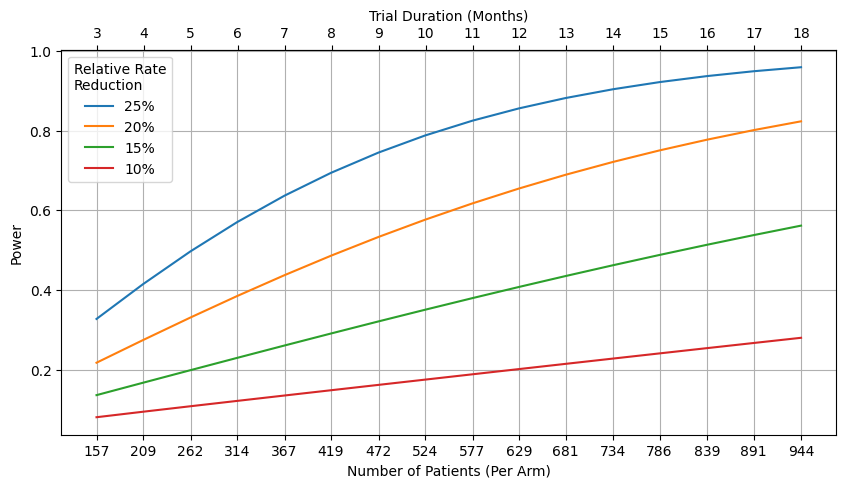

{'N': 889,
 'mu1': 1.0866551126516464,
 'mu2': 0.8693240901213172,
 'theta': 0.55852987749752,
 'duration': 1.0,
 'sig.level': 0.05,
 'power': 0.8004356660297959,
 'alternative': 'two.sided',
 'method': 'Two-sample Negative Binomial rates Tests (Equal Sizes)',
 'note': 'N is number in *each* group'}

In [32]:
# Only GI
tmp = df[df["department"].isin(["GI"])]
plot_power(tmp, lookahead_window=30)
compute_power_nb(tmp, trial_time=16.95, drop_factor=0.20, lookahead_window=30)

### ED within 30 days

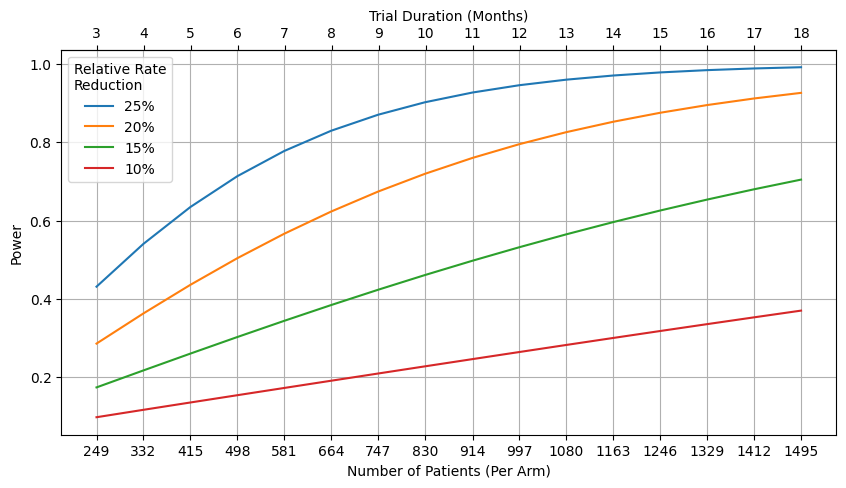

{'N': 1009,
 'mu1': 0.9059080962800875,
 'mu2': 0.72472647702407,
 'theta': 0.5080445615634355,
 'duration': 1.0,
 'sig.level': 0.05,
 'power': 0.8001324299951678,
 'alternative': 'two.sided',
 'method': 'Two-sample Negative Binomial rates Tests (Equal Sizes)',
 'note': 'N is number in *each* group'}

In [56]:
# Only GI + LU
tmp = df[df["department"].isin(["GI", "LU"])]
plot_power(tmp, lookahead_window=30)
compute_power_nb(tmp, trial_time=12.15, drop_factor=0.20, lookahead_window=30)

In [57]:
# monthly new patients
tmp.groupby("year_month")["mrn"].nunique().mean()

83.0909090909091

In [58]:
# number of ED visits within 90 days of clinic visit before first treatment date
tmp[["num_ED_30d", "num_ED_60d", "num_ED_90d"]].mean()

num_ED_30d    0.905908
num_ED_60d    0.991247
num_ED_90d    1.021882
dtype: float64

In [59]:
len(tmp)

914

### ED within 90 days

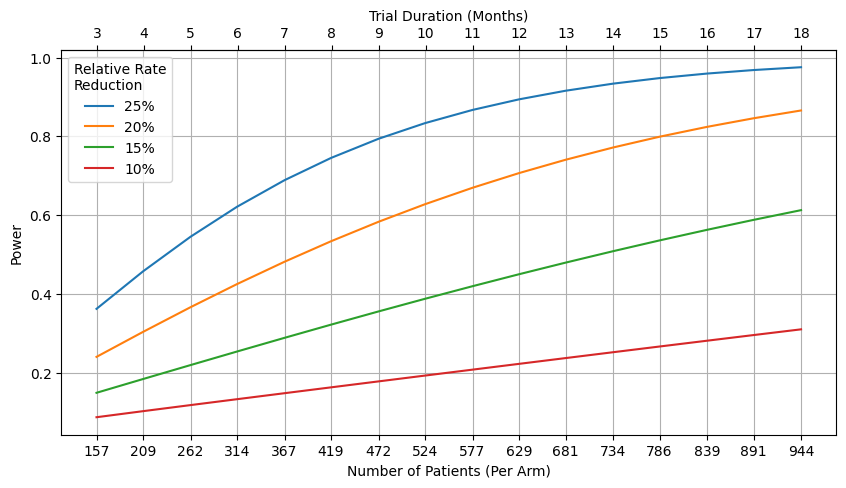

{'N': 792,
 'mu1': 1.2027729636048528,
 'mu2': 0.9622183708838823,
 'theta': 0.6358577253113263,
 'duration': 1.0,
 'sig.level': 0.05,
 'power': 0.8019146288488628,
 'alternative': 'two.sided',
 'method': 'Two-sample Negative Binomial rates Tests (Equal Sizes)',
 'note': 'N is number in *each* group'}

In [55]:
# Only GI
tmp = df[df["department"].isin(["GI"])]
plot_power(tmp, lookahead_window=90)
compute_power_nb(tmp, trial_time=15.1, drop_factor=0.20, lookahead_window=90)

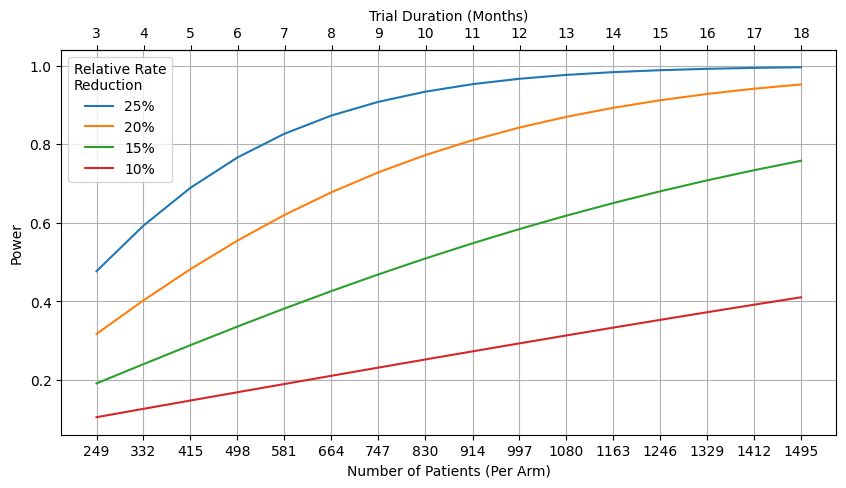

{'N': 890,
 'mu1': 1.0218818380743981,
 'mu2': 0.8175054704595186,
 'theta': 0.5783103879087541,
 'duration': 1.0,
 'sig.level': 0.05,
 'power': 0.800345718518953,
 'alternative': 'two.sided',
 'method': 'Two-sample Negative Binomial rates Tests (Equal Sizes)',
 'note': 'N is number in *each* group'}

In [52]:
# Only GI + LU
tmp = df[df["department"].isin(["GI", "LU"])]
plot_power(tmp, lookahead_window=90)
compute_power_nb(tmp, trial_time=10.72, drop_factor=0.20, lookahead_window=90)